# Dictation as the Natural User-input

Certainly. I'll provide an updated version of your JavaScript code that incorporates the speech recognition feature while focusing on the donor, nondonor, and general population scenarios. Here's the updated script from top to bottom:

```javascript
'use strict';

var scenarioVector = [0, 0, 1]; // Default to general population scenario
let beta = [];
let s0 = [];
let timePoints = [];
let recognition;

async function fetchCSV(url) {
    const response = await fetch(url);
    const text = await response.text();
    return text.split('\n').map(row => row.trim()).filter(row => row);
}

async function loadData() {
    try {
        // Fetch coefficients
        const coefficientsData = await fetchCSV('https://abikesa.github.io/flow/_downloads/b57ad99810799d0be5a9e18f54115561/b.csv');
        const [header, ...rows] = coefficientsData;
        beta = rows[0].split(',').map(Number);
        console.log('Coefficients loaded:', beta);

        // Fetch survival data
        const survivalData = await fetchCSV('https://abikesa.github.io/flow/_downloads/9c26f2afd014707dc60aefc8facbf60d/s0.csv');
        const [survivalHeader, ...survivalRows] = survivalData;
        timePoints = [];
        s0 = [];
        survivalRows.forEach(row => {
            const [time, survival] = row.split(',').map(Number);
            timePoints.push(time);
            s0.push(survival);
        });
        console.log('Survival data loaded:', {timePoints, s0});

        // Enable the calculate button after data is loaded
        document.getElementById('calculate-risk-button').disabled = false;
    } catch (error) {
        console.error('Error loading data:', error);
        alert('Error loading data. Please check the console for details.');
    }
}

function setupSpeechRecognition() {
    if ('webkitSpeechRecognition' in window) {
        recognition = new webkitSpeechRecognition();
        recognition.continuous = false;
        recognition.interimResults = false;

        recognition.onresult = function(event) {
            const result = event.results[0][0].transcript;
            document.getElementById('dictation-result').textContent = result;
            processDictationResult(result);
        };

        recognition.onerror = function(event) {
            console.error('Speech recognition error:', event.error);
        };
    } else {
        alert('Speech recognition is not supported in this browser.');
    }
}

function processDictationResult(result) {
    console.log('Processing:', result);
    
    const keywords = {
        donor: /donor/i,
        nondonor: /non\s*donor/i,
        general: /general\s*population/i
    };

    let scenario = 'genpop'; // Default scenario

    if (keywords.donor.test(result)) {
        scenario = 'donor';
    } else if (keywords.nondonor.test(result)) {
        scenario = 'nondonor';
    }

    console.log('Detected scenario:', scenario);
    document.getElementById('scenario-dropdown').value = scenario;
    selectScenario(scenario);
}

function selectScenario(scenario) {
    switch (scenario) {
        case 'donor':
            scenarioVector = [1, 0, 0];
            break;
        case 'nondonor':
            scenarioVector = [0, 1, 0];
            break;
        case 'genpop':
        default:
            scenarioVector = [0, 0, 1];
            break;
    }
    calculateMortalityRisk(scenario);
}

function calculateMortalityRisk(scenario) {
    if (beta.length === 0 || s0.length === 0 || timePoints.length === 0) {
        alert('Data is not yet loaded. Please wait.');
        return;
    }

    const logHR = beta.reduce((acc, curr, index) => acc + (curr * scenarioVector[index]), 0);
    const f0 = s0.map(s => (1 - s) * 100);
    const f1 = f0.map((f, index) => f * Math.exp(logHR));

    const colorSchemes = {
        'donor': 'rgba(0, 191, 255, 1)',
        'nondonor': 'rgba(255, 0, 255, 1)',
        'genpop': 'rgba(106, 168, 79, 1)'
    };

    const riskResults = timePoints.map((time, index) => `Risk at ${time.toFixed(2)} years: ${f1[index].toFixed(2)}%`);

    if (window.mortalityChart) {
        window.mortalityChart.destroy();
    }

    const ctx = document.getElementById('mortality-risk-graph').getContext('2d');
    window.mortalityChart = new Chart(ctx, {
        type: 'line',
        data: {
            labels: timePoints.map(t => t.toFixed(2)),
            datasets: [{
                label: 'Mortality Risk',
                data: f1,
                stepped: true,
                borderColor: colorSchemes[scenario],
                backgroundColor: colorSchemes[scenario].replace('1)', '0.2)'),
                borderWidth: 3
            }]
        },
        options: {
            responsive: true,
            maintainAspectRatio: false,
            scales: {
                x: {
                    title: {
                        display: true,
                        text: 'Timepoints (years)'
                    }
                },
                y: {
                    title: {
                        display: true,
                        text: 'Mortality Risk (%)'
                    },
                    suggestedMin: 0,
                    suggestedMax: 80,
                    stepSize: 20
                }
            }
        }
    });

    document.getElementById("mortality-risk-results").innerText = riskResults.join('\n');
}

// Load data and set up speech recognition when the page loads
window.addEventListener('load', function() {
    loadData();
    setupSpeechRecognition();
});

// Attach event listener to the dropdown to update the scenarioVector
document.getElementById("scenario-dropdown").addEventListener("change", function() {
    selectScenario(this.value);
});

// Attach event listener to the calculate button
document.getElementById("calculate-risk-button").addEventListener("click", function() {
    const scenario = document.getElementById("scenario-dropdown").value;
    calculateMortalityRisk(scenario);
});

// Add an event listener for the dictation button
document.getElementById('start-dictation').addEventListener('click', function() {
    if (recognition) {
        recognition.start();
    } else {
        alert('Speech recognition is not set up.');
    }
});
```

This updated script includes the following changes:

1. It incorporates the speech recognition setup and processing.
2. The `processDictationResult` function now looks for keywords related to donor, non-donor, and general population scenarios.
3. The `selectScenario` function has been simplified to only handle these three scenarios.
4. The color scheme in `calculateMortalityRisk` has been updated to only include these three scenarios.

To make this work, you'll need to update your HTML to include the dictation button and result display:

```html
<button id="start-dictation">Start Dictation</button>
<div id="dictation-result"></div>
```

This implementation allows users to select a scenario either through the dropdown menu or by using voice commands. The voice recognition will look for keywords like "donor", "non-donor", or "general population" in the spoken input.

Remember that speech recognition may not work in all browsers and requires an internet connection. Also, the accuracy of speech recognition can vary based on factors like accent, background noise, and microphone quality.

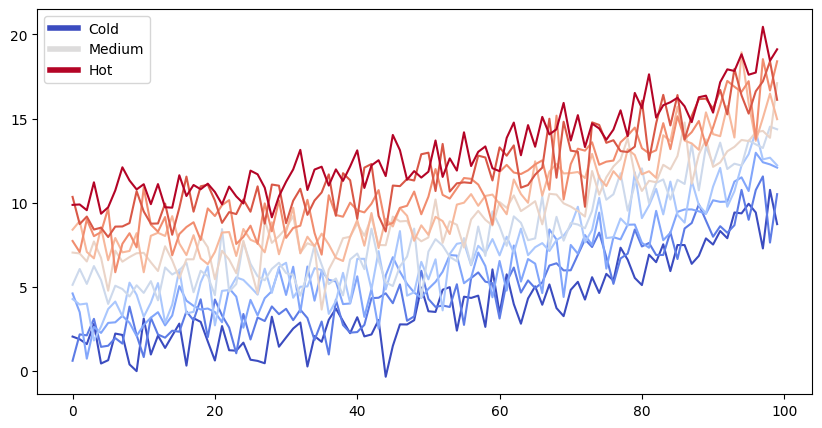

In [5]:

import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from matplotlib import rcParams

# Fixing random state for reproducibility
np.random.seed(19680801)

N = 10
data = [np.logspace(0, 1, 100) + np.random.randn(100) + ii for ii in range(N)]
data = np.array(data).T
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

fig, ax = plt.subplots(figsize=(10, 5))
lines = ax.plot(data)
ax.legend(custom_lines, ['Cold', 'Medium', 'Hot']);

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)